In [5]:
%matplotlib inline
import numpy as np
from scipy import integrate
from scipy.special import gamma
from scipy.optimize import fsolve, basinhopping
import matplotlib.pyplot as plt
import qutip.ipynbtools
from ipywidgets import FloatProgress
import qutip.parallel
from scipy import signal
import scipy.io
import gc
import matplotlib.colors as colors
from IPython.display import clear_output, Javascript, Markdown
import datetime
import math
import uuid
import os
import time
import ipyparallel
import qutip.ui
import random
import sys
from bayes_opt import BayesianOptimization
import nbimporter
from _create_pdf import create_spins;
from _helper_functions import tsallis, cauchy, find_nearest, odeintz, find_nearest_sorted_left
from _steady_state import a_steady
from _pulse_rwa import pulse_rwa
from _mbes import mbes, mbes_soc
from _do_calculation import do_calculation, do_calculation_stimulated, do_calculation_soc, do_calculation_soc_pump_only
#%qtconsole

Importing Jupyter notebook from _create_pdf.ipynb
Importing Jupyter notebook from _helper_functions.ipynb
Importing Jupyter notebook from _steady_state.ipynb
Importing Jupyter notebook from _pulse_rwa.ipynb


In [6]:
gcoll = 10.7*np.pi #HWHM
q = 1.39
quali = 949
fr = 3.4892e3;
kappa = np.pi*fr/quali #HWHM
delta = 0*2*np.pi
deltac = 0*2*np.pi
gperp = 2*np.pi*0.09 #HWHM
gpar = 2*np.pi*.001#0.001 #HWHM
gammaq = 2*np.pi*9.4 #FWHM
nbins = 701#701#5000#20
#g0 = gcoll/sqrt(nspins)
print(kappa)

11.550732441417814


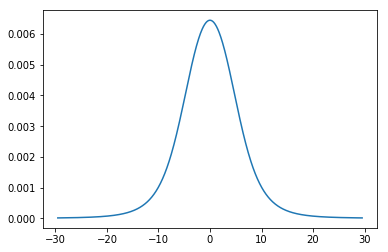

In [7]:
f, gs, spins, pdf = create_spins(gcoll, q, gammaq, nbins, holes=False, inhomo=True, hyperfine=True)

plt.plot(f, pdf)

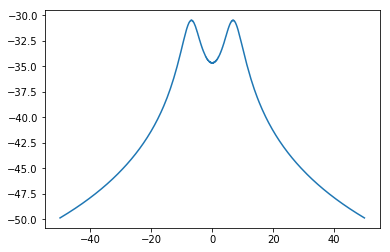

In [9]:
initsteady = (0.1,0.1)
fstart = 50
deltaarr = np.linspace(-fstart*2*np.pi,fstart*2*np.pi, 2000)
etasteady = 0.00001
losasteady = np.zeros(np.shape(deltaarr))
losareal = np.zeros(np.shape(deltaarr))
losaimag = np.zeros(np.shape(deltaarr))

newinit = initsteady
for i, delt in enumerate(deltaarr):
    ar, ai = a_steady(etasteady, delt, gs, spins, gpar, gperp, kappa, newinit)
    newinit = (ar, ai)
    losasteady[i] = ai**2+ar**2
    losareal[i] = ar
    losaimag[i] = ai

fig = plt.figure()
plt.plot(deltaarr/2/np.pi, 10*np.log10(losasteady/0.0000000001))
#deltaarr[find(losasteady == max(losasteady))]/2/pi

In [10]:
def do_calculation(drive, tlistpump, tlistafter, init):

    #this should be very fast as well because scipy uses fortran 
    asolpump, infodict = odeintz(mbes, init, tlistpump, args=(drive,), full_output=True)
    init2 = asolpump[-1,:]
    asoldecay = odeintz(mbes, init2, tlistafter, args=(0,))
    
    #this is necessary because we are clustering the spins
    asolpump[:,2::2] = asolpump[:,2::2]*pdf
    asolpump[:,1::2] = asolpump[:,1::2]*pdf
    asoldecay[:,2::2] = asoldecay[:,2::2]*pdf
    asoldecay[:,1::2] = asoldecay[:,1::2]*pdf
    return asolpump, asoldecay, infodict
    #solution is that the first entry is the cavity, and then the first spin (sigma-, sigmaz) then the second etc...
    
def do_calculation_stimulated(drivepump, driveprobe, tlistpump, tlistwait, tlistprobe, tlistafter, init):
    #this should be very fast as well because scipy uses fortran 
    asolpump, infodict = odeintz(mbes, init, tlistpump, args=(drivepump,), full_output=True)
    init2 = asolpump[-1,:]
    asolwait = odeintz(mbes, init2, tlistwait, args=(0,))
    init3 = asolwait[-1,:]
    asolprobe = odeintz(mbes, init3, tlistprobe, args=(driveprobe,))
    init4 = asolprobe[-1,:]
    asoldecay = odeintz(mbes, init4, tlistafter, args=(0,))
    
    #this is necessary because we are clustering the spins
    asolpump[:,2::2] = asolpump[:,2::2]*pdf
    asolpump[:,1::2] = asolpump[:,1::2]*pdf
    asoldecay[:,2::2] = asoldecay[:,2::2]*pdf
    asoldecay[:,1::2] = asoldecay[:,1::2]*pdf
    asolwait[:, 2::2] = asolwait[:, 2::2]*pdf
    asolwait[:, 1::2] = asolwait[:, 1::2]*pdf
    asolprobe[:, 1::2] = asolprobe[:, 1::2]*pdf
    asolprobe[:, 2::2] = asolprobe[:, 2::2]*pdf
    return asolpump, asolwait, asolprobe, asoldecay, infodict
    
def do_calculation_soc(ilist, qlist, tlistpump, tlistafter, init):
    """this method is if you want to use shaped drive, which means that the drive-lists as i and q channels
    shape should be given as first arguments
    
    factor is the number by which one has to multiply tlistpump, to get a all integer list as 0,1,2,3...numsteps-1
    """
    #this should be very fast as well because scipy uses fortran 
    asolpump, infodict = odeintz(mbes_soc, init, tlistpump, args=(ilist, qlist, tlistpump), full_output=True)
    init2 = asolpump[-1,:]
    asoldecay = odeintz(mbes, init2, tlistafter, args=(0,))

    asolpump[:,2::2] = asolpump[:,2::2]*pdf
    asolpump[:,1::2] = asolpump[:,1::2]*pdf
    asoldecay[:,2::2] = asoldecay[:,2::2]*pdf
    asoldecay[:,1::2] = asoldecay[:,1::2]*pdf
    
    return asolpump, asoldecay, infodict
    #solution is that the first entry is the cavity, and then the first spin (sigma-, sigmaz) then the second etc...
    
def do_calculation_soc_pump_only(ilist, qlist, tlist, init):
    """this method is if you want to use shaped drive, which means that the drive-lists as i and q channels
    shape should be given as first arguments
    
    it doesn't use a decay afterwards such that it is better for genetic algorithm
    
    factor is the number by which one has to multiply tlistpump, to get a all integer list as 0,1,2,3...numsteps-1
    """
    #this should be very fast as well because scipy uses fortran
    asol, infodict = odeintz(mbes_soc, init, tlist, args=(ilist, qlist, tlist), full_output=True)
    
    asol[:,2::2] = asol[:,2::2]*pdf
    asol[:,1::2] = asol[:,1::2]*pdf
    
    return asol, infodict
    #solution is that the first entry is the cavity, and then the first spin (sigma-, sigmaz) then the second etc...

## Calibrate power

In [12]:
pumptime = 200e-3
decaytime = 300e-3
dt = 0.5e-3
numsteps = int(pumptime/dt)
tlist = np.arange(0,pumptime+dt,dt)
tlistdecay = np.arange(0, decaytime+dt, dt)

# test time it takes to calculate


init = np.ones(nbins*2+1)*(-1)
init[0] = 0
init[1::2] = 0

pulsei = np.ones((len(tlist)))


pin = np.arange(-45, 0,1)
aref = 2*np.pi*50

alos = np.zeros((len(pin), len(tlist)+len(tlistdecay)))
szlos = np.zeros(np.shape(alos))

for ctr, p in enumerate(pin):
    dr = aref*10**(p/20.)
    asolpump, asoldecay, infodict = do_calculation(dr, tlist, tlistdecay, init)
    alos[ctr, : ] = np.hstack((abs(asolpump[:,0])**2, abs(asoldecay[:,0])**2))
    szlos[ctr, :] = np.hstack((np.real(np.sum(asolpump[:, 2::2], axis=1)), np.real(np.sum(asoldecay[:, 2::2], axis=1))))

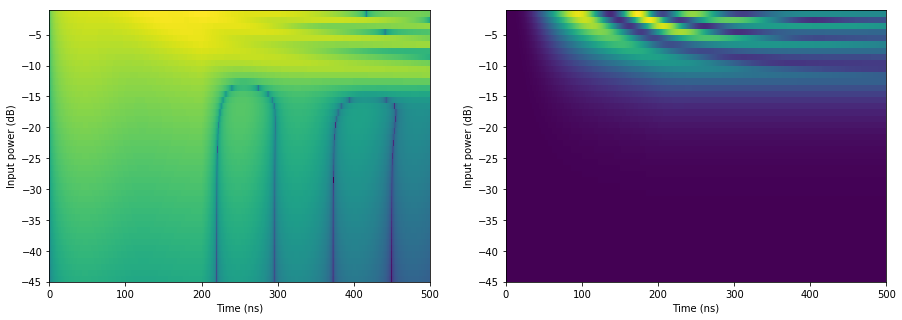

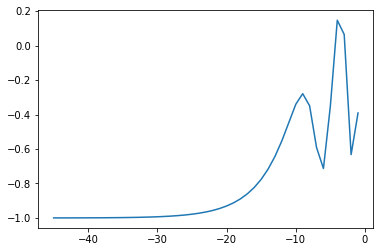

In [13]:
tplot = np.linspace(0, 1000*(pumptime+decaytime), len(tlist)+len(tlistdecay))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

ax1.pcolor(tplot, pin, alos, norm=colors.LogNorm())
ax1.set_xlabel('Time (ns)')
ax1.set_ylabel('Input power (dB)');

ax2.pcolor(tplot, pin, szlos)
ax2.set_xlabel('Time (ns)')
ax2.set_ylabel('Input power (dB)');

f = plt.figure()
idx = min(range(len(tplot)), key=lambda i: abs(tplot[i]-pumptime*1000))
plt.plot(pin, szlos[:, idx])

In [14]:
tp = np.linspace(0,pumptime,numsteps)
wgrund = np.pi/tp[-1]


def calculate_fitness(**kwargs):
    if kwargs:
        fcomps = np.array([kwargs[i] for i in kwargs])
    fcompsi = fcomps[:int(len(fcomps)/2)]
    fcompsq = fcomps[int(len(fcomps)/2):]
    pulsei = pulse_rwa(tp, [wgrund, fcompsi])
    pulseq = pulse_rwa(tp, [wgrund, fcompsq])
    init = np.ones(nbins*2+1)*(-1)
    init[0] = 0
    init[1::2] = 0
    solution, infodict = do_calculation_soc_pump_only(pulsei, pulseq, tp, init)
    return np.real(np.sum(solution[:, 2::2], axis=1)[-1])

In [22]:
class Bayes:
    def __init__(self):
        self.number_fcp = 8
        self.max_ampl = 2*np.pi*90/self.number_fcp
        self.pbounds = {}
        for i in range(self.number_fcp*2):
            self.pbounds['p'+str(i)] = (-self.max_ampl, self.max_ampl)
        self.number_initial = 90
        self.n_iter = 800
        self
            
            
    def main(self, init=None):
        populationPulse = np.zeros((numsteps, 2))
        populationFourier = np.zeros((self.number_fcp, 2))
        populationFitness = np.zeros((1))
        populationSolution = np.zeros((numsteps, 2*nbins+1), dtype=complex)
        
        frand = np.random.uniform(-self.max_ampl, self.max_ampl, (self.number_fcp, 2))
        
        
        
        bo = BayesianOptimization(calculate_fitness, self.pbounds)
        
        if init:
            guess = {}
            for i, val in enumerate(init):
                guess['p'+str(i)] = [val]
            bo.explore(guess)
        
        bo.maximize(init_points=self.number_initial, n_iter=self.n_iter, kappa=3)
        
        return bo

In [23]:
bayes = Bayes()
ret2 = bayes.main(init=[ 74.56466659, -74.65413536, -73.42280921, -71.23052582,
           8.67695396, -70.25159013, -69.19537669, -20.33609285,
         -75.41802364,  75.32826822,  71.95575526,  70.38381166,
          70.30803821,  69.92008994,  12.85117779,  64.84087746])

Initialization
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |        p0 |        p1 |       p10 |       p11 |       p12 |       p13 |       p14 |       p15 |        p2 |        p3 |        p4 |        p5 |        p6 |        p7 |        p8 |        p9 | 
    1 | 00m04s |    0.29035 |   74.5647 |  -74.6541 |   71.9558 |   70.3838 |   70.3080 |   69.9201 |   12.8512 |   64.8409 |  -73.4228 |  -71.2305 |    8.6770 |  -70.2516 |  -69.1954 |  -20.3361 |  -75.4180 |   75.3283 | 
    2 | 00m04s |   -0.67116 |  -16.6123 |  -69.2147 |   -9.9523 |   -2.6044 |  -46.1159 |    8.2022 |  -27.3665 |  -17.2166 |    0.3714 |   56.0317 |   43.0142 |   23.8196 |   26.8173 |  -52.5302 |   17.3582 |  -66.3957 | 
    3 | 00m04s |   -0.76015 |   44.3273 |    5.3551 |  -41.2740 |  -22.1319 |   36.4350 |   44

   35 | 00m04s |   -0.67852 |   31.4265 |   27.7855 |   28.2524 |  -43.2971 |    8.6856 |  -17.7126 |  -18.2187 |   41.0624 |  -65.0421 |   46.3307 |  -49.2143 |  -61.4126 |  -26.7287 |   51.8043 |  -59.8792 |   46.9142 | 
   36 | 00m04s |   -0.91284 |    4.8407 |   -2.8073 |  -23.3549 |   21.3579 |  -44.5914 |  -53.3860 |   57.4647 |  -17.1412 |   21.1396 |   27.3660 |  -40.0019 |   25.6800 |  -69.6715 |  -32.9468 |   21.4474 |   43.6101 | 
   37 | 00m04s |   -0.62099 |  -29.5459 |  -23.2272 |   46.7871 |   -5.6671 |  -35.4929 |   14.2743 |   33.4282 |   19.0298 |  -67.1380 |   37.8893 |   52.1197 |   -2.5872 |  -36.8181 |  -11.7362 |   57.5406 |  -60.5164 | 
   38 | 00m04s |   -0.75646 |  -19.3684 |   32.0264 |  -10.3983 |  -52.4486 |   22.8109 |  -58.6367 |   -9.6449 |   39.5803 |   60.0367 |   21.4641 |  -44.1400 |  -70.2875 |  -48.3452 |  -60.7984 |  -62.2417 |   -2.7036 | 
   39 | 00m04s |   -0.65024 |   29.3073 |   11.6931 |   31.3196 |  -23.2363 |  -22.7389 |   11.9412 |   62.1

   72 | 00m04s |   -0.59861 |   45.4931 |   31.8862 |   25.5847 |   64.4897 |   42.9363 |  -45.5526 |  -21.3738 |  -30.7059 |   30.9592 |  -20.0464 |   69.8660 |   26.9268 |  -68.4506 |   50.2552 |   55.2344 |  -60.9431 | 
   73 | 00m04s |   -0.65105 |   -7.9267 |   34.4695 |  -42.6484 |  -40.6189 |  -51.0242 |   -8.3356 |  -68.2082 |   70.1649 |   -0.7740 |   29.3418 |   11.8697 |  -19.1876 |  -55.9885 |  -26.1836 |   67.5104 |  -40.5486 | 
   74 | 00m04s |   -0.85138 |  -17.1111 |  -20.5203 |  -17.3900 |   -3.8508 |  -59.6517 |  -27.7105 |   21.1509 |  -33.1136 |  -59.0042 |   -9.7718 |   40.6456 |  -17.4658 |    6.2006 |  -53.3283 |  -32.2623 |  -13.1019 | 
   75 | 00m04s |   -0.64936 |   67.1448 |   31.4134 |  -13.5668 |    9.8356 |   62.6900 |   22.5691 |  -16.8593 |   61.5979 |   68.4949 |   28.2341 |  -67.9206 |  -50.5345 |   11.3760 |  -26.0848 |  -39.4383 |  -43.4434 | 
   76 | 00m04s |   -0.82322 |  -11.3683 |  -43.3843 |   10.0620 |   20.8693 |  -38.9983 |  -12.3170 |   38.6

  107 | 01m34s |   -0.39383 |   70.6858 |   70.6858 |   70.6858 |   70.6858 |   70.6858 |  -70.6858 |   70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |   70.6858 |  -70.6858 |  -70.6858 |   70.6858 | 
  108 | 01m37s |    0.24903 |  -70.6858 |   70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |   70.6858 |   70.6858 |   70.6858 |   70.6858 |   70.6858 |   70.6858 |   70.6858 |  -70.6858 | 
  109 | 01m36s |   -0.42392 |   70.6858 |  -70.6858 |   70.6858 |   70.6858 |   70.6858 |   70.6858 |   70.6858 |   70.6858 |  -70.6858 |  -70.6858 |   70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |   70.6858 |   70.6858 | 
  110 | 01m45s |    0.17966 |  -70.6858 |   70.6858 |  -70.6858 |   70.6858 |  -70.6858 |  -70.6858 |   70.6858 |  -70.6858 |   70.6858 |   70.6858 |   70.6858 |   70.6858 |   70.6858 |   70.6858 |   70.6858 |  -70.6858 | 
  111 | 01m37s |    0.16613 |  -70.6858 |   70.6858 |  -70.6858 |   70.6858 |   70.6858 |  -70.6858 |  -70.6

/home/andreas/Diverses/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -2.41288509e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


  112 | 01m38s |   -0.40949 |  -70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |   70.6858 |  -70.6858 |  -70.6858 |   70.6858 |   70.6858 |   70.6858 |  -70.6858 |   70.6858 |   70.6858 |   70.6858 |  -70.6858 | 
  113 | 01m34s |   -0.00921 |  -70.6858 |   70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |   70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |   70.6858 |   70.6858 |   70.6858 |   70.6858 |  -70.6858 | 
  114 | 01m36s |    0.13359 |   70.6858 |  -70.6858 |   70.6858 |  -70.6858 |   70.6858 |   70.6858 |  -70.6858 |   70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |   70.6858 |  -70.6858 |   70.6858 | 
  115 | 01m40s |   -0.39190 |  -70.6858 |   70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |   70.6858 |   70.6858 |   70.6858 |   70.6858 |   70.6858 |   70.6858 |   70.6858 |   70.6858 |   70.6858 |   70.6858 | 
  116 | 01m49s |   -0.21383 |   70.6858 |   70.6858 |  -70.6858 |   70.6858 |   70.6858 |  -70.6858 |   70.6

  149 | 02m25s |    0.14115 |  -70.6858 |   70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |   70.6858 |   70.6858 |  -70.6858 |  -70.6858 |   70.6858 |  -70.6858 |   70.6858 |  -70.6858 | 
  150 | 02m23s |    0.13396 |  -70.6858 |   70.6858 |  -70.6858 |   70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |   70.6858 |   -4.7244 |   70.6858 |   70.6858 |   70.6858 |  -70.6858 |   70.6858 |  -70.6858 | 
  151 | 02m28s |   -0.27823 |  -70.6858 |   70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |   70.6858 |  -70.6858 |  -70.6858 |   70.6858 |   70.6858 |  -70.6858 |   70.6858 |  -70.6858 |  -70.6858 | 
  152 | 02m33s |   -0.44609 |  -70.6858 |  -70.6858 |  -70.6858 |   70.6858 |   70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |   70.6858 |   70.6858 |  -70.6858 |   70.6858 |   70.6858 |  -70.6858 |   70.6858 |  -70.6858 | 
  153 | 02m23s |   -0.16914 |  -70.6858 |   70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |  -70.6

  186 | 02m58s |    0.07742 |   70.6858 |  -70.6858 |   70.6858 |   70.6858 |   70.6858 |   70.6858 |  -70.2092 |   70.6858 |  -70.6858 |  -70.6858 |   70.6858 |   70.6858 |  -70.6858 |   70.6858 |  -70.6858 |   70.6858 | 
  187 | 03m11s |    0.09715 |   70.6858 |  -70.6858 |   70.6858 |   70.6858 |   70.6858 |  -60.2809 |   70.6858 |  -70.6858 |  -70.6858 |  -64.8034 |  -70.6858 |   69.9165 |  -64.0021 |   70.5934 |  -70.6858 |   70.6858 | 
  188 | 03m09s |    0.18154 |   70.6858 |  -70.6858 |   70.6858 |   70.6858 |   70.6858 |   70.6858 |   70.6858 |  -68.1099 |  -70.6858 |   70.2951 |  -70.6761 |  -70.6747 |  -70.3560 |  -70.6858 |  -70.6858 |   70.6858 | 
  189 | 02m57s |    0.21361 |  -70.6858 |   70.6858 |  -70.6858 |  -70.6858 |  -70.2373 |  -70.6858 |  -16.2042 |  -70.6858 |   70.6858 |   70.6858 |   70.6858 |  -10.0941 |  -70.6858 |   70.6858 |   70.6858 |  -70.6858 | 
  190 | 03m02s |   -0.19726 |  -70.6858 |   70.6858 |   70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |   70.6

/home/andreas/Diverses/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -4.61358022e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


  200 | 02m47s |   -0.01689 |  -70.6858 |   70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |  -68.2562 |   70.6858 |  -63.2907 |   70.6044 |   69.5525 |   70.6858 |   70.6858 |  -69.1743 |   70.6858 |  -70.6858 | 
  201 | 02m44s |    0.07185 |  -70.6858 |   70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |   70.6858 |  -70.6858 |   70.6858 |   70.6858 |  -70.6858 |  -70.6858 |   54.7124 |  -70.6858 |   70.6858 |  -70.6858 | 
  202 | 02m44s |    0.16453 |   70.6858 |  -70.6858 |   70.6858 |   38.5298 |   70.6858 |  -14.3039 |   37.6002 |   70.6858 |  -70.6858 |  -28.3277 |  -70.6858 |  -70.6858 |   70.6858 |  -70.6858 |  -70.6858 |   70.6858 | 
  203 | 02m44s |    0.01054 |   70.6858 |  -70.6858 |   70.6858 |  -65.0647 |   70.6858 |  -41.5202 |   70.6858 |   70.6858 |  -70.6858 |  -47.3105 |  -70.6858 |   70.6858 |   31.9338 |   70.6858 |  -70.6858 |   70.6858 | 


/home/andreas/Diverses/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -9.74306624e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


  204 | 02m58s |   -0.04135 |  -70.6858 |   70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |  -22.4974 |  -70.6858 |   70.6858 |  -70.6858 |  -39.7429 |  -70.5919 |  -53.2625 |   70.6858 |  -70.6858 |   70.6858 |  -70.6858 | 
  205 | 02m41s |    0.16342 |  -70.6858 |   70.6858 |  -70.6858 |   13.1191 |  -70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |   70.6858 |   70.6858 |   70.6858 |  -70.6858 |   -8.7893 |   70.6858 |   70.6858 |  -70.6858 | 
  206 | 02m52s |    0.23571 |  -70.6858 |   70.6858 |  -70.6858 |  -70.6858 |  -68.7898 |  -70.6858 |  -70.6858 |   70.6858 |   70.6858 |   70.6858 |   70.6858 |   70.6858 |   70.6858 |  -70.6858 |   70.6858 |  -70.6858 | 
  207 | 02m50s |    0.14800 |   70.6858 |  -70.6858 |   70.6858 |   70.6858 |   51.5088 |   70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |  -70.3765 |  -70.6858 |   70.6858 |   -4.5439 |  -70.6858 |   70.6858 | 
  208 | 02m51s |    0.00478 |   70.6858 |  -70.6858 |   70.6858 |  -70.6858 |   70.6858 |  -70.6858 |   70.6

  241 | 02m34s |    0.08065 |   70.6858 |  -70.6858 |   70.6858 |  -70.6858 |  -70.6858 |   70.6858 |   70.6858 |   70.6858 |  -70.6858 |   70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |   70.6858 | 
  242 | 02m49s |   -0.05964 |   70.6858 |  -70.6858 |  -70.6858 |   70.6858 |  -70.6858 |   70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |   70.6858 |  -70.6858 |   70.6858 | 
  243 | 02m47s |    0.03798 |   70.6858 |  -70.6858 |   49.6571 |  -70.6858 |   70.6858 |  -70.6858 |   70.6858 |   70.6858 |  -70.6858 |   70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |  -68.5620 |  -70.6858 |   70.6858 | 
  244 | 02m43s |    0.22591 |  -70.6858 |   70.6858 |  -70.6858 |  -70.6858 |    5.0658 |  -70.6858 |  -70.6858 |  -70.6858 |   70.6858 |   70.6858 |   70.6858 |   70.6858 |   50.8904 |  -70.6858 |   70.6858 |  -70.6858 | 
  245 | 02m02s |   -0.10485 |  -70.6858 |   70.6858 |   70.6858 |   70.6858 |   70.6858 |   70.6858 |   70.6

  278 | 00m11s |   -0.38242 |  -66.4335 |  -36.9563 |   62.6985 |   49.6016 |   50.8069 |    8.0885 |   60.1345 |  -25.1298 |   44.1419 |  -47.8174 |  -35.8342 |   12.7287 |   51.8733 |  -32.6147 |  -69.5603 |   57.8703 | 
  279 | 02m22s |    0.00239 |  -70.6858 |   70.6858 |  -70.6858 |  -70.6858 |   32.6297 |  -33.2157 |   63.4803 |  -70.6858 |   70.6858 |   30.6951 |  -70.6858 |   63.7242 |  -34.1885 |  -40.0584 |   70.6858 |  -70.6858 | 
  280 | 02m38s |   -0.21681 |   70.6858 |   70.6858 |   70.6858 |   70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |   70.6858 |   70.6858 |  -70.6858 |  -64.6133 |   70.6858 |   70.6858 |   70.6858 |  -70.6858 |   70.6858 | 
  281 | 02m21s |   -0.03419 |   70.6858 |  -70.6858 |   70.6858 |   47.4915 |    3.7465 |  -42.7779 |   29.8354 |   43.5736 |  -70.6858 |   15.2317 |  -70.6858 |  -24.2236 |   16.9264 |   -7.7537 |  -56.9207 |   70.6858 | 
  282 | 02m29s |   -0.39792 |   70.6858 |  -70.6858 |   70.6858 |   70.6858 |   70.6858 |  -38.3800 |  -45.1

/home/andreas/Diverses/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.0001182]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


  284 | 02m38s |    0.15257 |  -70.6858 |   70.6858 |  -70.6858 |  -70.6858 |  -16.8497 |  -70.6858 |  -70.6858 |  -54.8704 |   46.9491 |   67.5618 |    0.7305 |   70.6858 |   70.6858 |  -70.6858 |   70.6858 |  -70.6858 | 
  285 | 02m30s |   -0.25422 |  -70.6858 |  -70.6858 |   70.6858 |   70.6858 |   70.6858 |   70.6858 |   70.6858 |   70.6858 |  -70.6858 |   68.5952 |   70.6858 |  -70.6858 |   70.6858 |  -70.6858 |   70.6858 |  -66.9493 | 
  286 | 02m24s |   -0.22505 |  -68.2041 |   39.9529 |  -57.2935 |  -67.8521 |    3.1242 |  -20.5820 |   10.0324 |  -47.2502 |  -59.2118 |  -59.2795 |    4.9559 |  -56.3598 |   52.1669 |   59.4033 |   68.4540 |  -70.5902 | 
  287 | 02m27s |    0.03666 |  -70.6858 |   70.6858 |  -70.6858 |   70.6180 |  -70.6858 |   70.6858 |  -70.6858 |  -70.6858 |   70.6858 |  -70.6858 |   70.6858 |  -70.6858 |   70.6858 |   70.6858 |   70.6858 |  -70.6858 | 
  288 | 02m27s |   -0.22570 |   70.6858 |  -70.6858 |   70.6858 |   18.2075 |   70.6858 |  -70.6858 |  -70.6

/home/andreas/Diverses/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00018967]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


  294 | 02m25s |   -0.08900 |  -66.0054 |   65.2644 |  -57.4508 |    7.5856 |  -58.3380 |  -54.4583 |  -62.0693 |  -65.1588 |   39.5362 |   60.4862 |   35.3340 |  -39.4413 |  -20.1742 |    1.9846 |   69.8491 |  -64.7553 | 
  295 | 02m37s |   -0.18075 |   56.1495 |  -69.0535 |   65.6100 |    8.6781 |  -27.4767 |   60.5073 |  -37.0760 |   39.3864 |  -56.6832 |  -61.9973 |  -31.0334 |  -20.3618 |  -12.3519 |   68.4278 |  -70.4883 |   55.2939 | 
  296 | 02m37s |   -0.25666 |  -57.1443 |   67.9958 |  -30.0351 |   35.1750 |  -53.7398 |   36.4824 |   63.4787 |  -45.7648 |   51.3160 |   12.7342 |   58.4430 |   -9.6122 |   67.6351 |   65.8054 |   69.0771 |  -49.6376 | 
  297 | 02m26s |   -0.16315 |  -66.5497 |   67.3342 |  -30.3198 |  -27.8587 |  -33.9571 |  -50.5460 |  -15.0137 |  -12.9645 |   64.6749 |   13.2125 |   59.8727 |   19.6302 |   68.5605 |   48.5300 |   59.4371 |  -48.0335 | 
  298 | 02m33s |   -0.32730 |  -69.6170 |   61.8180 |  -56.5095 |  -54.8821 |   36.5055 |   -8.7461 |   28.6

  331 | 03m51s |    0.15807 |   70.6858 |  -70.6858 |   70.6858 |   26.1789 |   70.6858 |   20.3997 |   70.6858 |   61.4792 |  -70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |   63.6080 |  -36.6689 |  -61.6540 |   70.6858 | 
  332 | 03m52s |   -0.18920 |   70.6858 |  -70.6858 |  -70.6858 |   69.9645 |   70.6858 |   70.6858 |   65.7114 |  -70.6858 |   17.9788 |   70.6858 |   70.2290 |  -70.6858 |   29.5287 |  -57.6351 |   70.6858 |  -70.6858 | 
  333 | 03m32s |   -0.15978 |  -70.6858 |   70.6858 |  -56.8358 |  -70.6858 |  -70.6858 |  -20.1348 |   70.6858 |   52.4430 |  -23.4657 |   26.1643 |  -27.1630 |   54.7725 |  -48.4099 |   48.1688 |   70.6858 |  -70.6858 | 
  334 | 03m54s |   -0.18047 |   70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |  -70.6858 |   70.6858 |  -24.8853 |   -9.0861 |   31.0504 |  -42.5966 |   70.6858 |   10.2236 |   70.6858 |  -70.6858 |   70.6858 | 
  335 | 03m47s |   -0.30167 |  -70.6858 |   70.6858 |   70.6858 |   70.6858 |   70.6858 |   70.6858 |  -15.9

/home/andreas/Diverses/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.00012212]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


  353 | 03m44s |   -0.23650 |  -70.6846 |   70.6858 |  -69.9055 |   32.0844 |   50.4269 |   70.6858 |   30.2603 |  -70.5507 |   70.6858 |  -38.0118 |   70.6858 |   63.4917 |  -51.9570 |  -70.6858 |  -70.6858 |   61.0880 | 
  354 | 04m16s |   -0.31348 |  -70.6858 |  -70.6858 |  -70.6858 |  -51.0488 |  -45.4019 |  -35.1424 |   53.9555 |   59.4773 |  -25.4742 |  -57.4650 |   26.5931 |  -13.2891 |   49.8625 |  -70.6858 |   70.6858 |  -70.6858 | 
  355 | 03m59s |   -0.20706 |   70.6858 |  -70.6858 |  -70.6858 |   70.6858 |   70.6858 |   70.6858 |  -58.9680 |  -70.6858 |   70.6858 |  -70.6858 |  -70.6858 |   70.6858 |   70.6858 |   70.6858 |  -70.6858 |   70.6858 | 
  356 | 04m15s |   -0.54929 |   70.0208 |   70.6858 |   70.6858 |   70.6858 |   70.6858 |   70.6858 |   70.6858 |   67.2805 |   70.6858 |   70.6858 |   70.6858 |   70.6858 |   70.6858 |   67.6650 |   70.6858 |   70.3209 | 
  357 | 04m14s |   -0.27304 |   62.8374 |  -45.8333 |   62.9484 |   70.3944 |  -69.2458 |   56.8059 |   40.8

KeyboardInterrupt: 

In [ ]:
%qtconsole